In [118]:
# Suppress warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
import sklearn.metrics as metrics
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import pointbiserialr
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [119]:
df = pd.read_csv("bookings.csv")

In [120]:
df['country'].fillna('unknown', inplace = True)
df['children'].fillna(0, inplace = True)

In [121]:
df.describe(include = 'number').T
#37% of guests cancel!

,count,mean,std,min,25%,50%,75%,max
booking_id,119390.0000,59695.5000,34465.0687,1.0000,29848.2500,59695.5000,89542.7500,119390.0000
is_canceled,119390.0000,0.3704,0.4829,0.0000,0.0000,0.0000,1.0000,1.0000
lead_time,119390.0000,104.0114,106.8631,0.0000,18.0000,69.0000,160.0000,737.0000
arrival_date_year,119390.0000,2016.1566,0.7075,2015.0000,2016.0000,2016.0000,2017.0000,2017.0000
arrival_date_month,119390.0000,6.5525,3.0906,1.0000,4.0000,7.0000,9.0000,12.0000
arrival_date_week_number,119390.0000,27.1652,13.6051,1.0000,16.0000,28.0000,38.0000,53.0000
arrival_date_day_of_month,119390.0000,15.7982,8.7808,1.0000,8.0000,16.0000,23.0000,31.0000
stays_in_weekend_nights,119390.0000,0.9276,0.9986,0.0000,0.0000,1.0000,2.0000,19.0000
stays_in_week_nights,119390.0000,2.5003,1.9083,0.0000,1.0000,2.0000,3.0000,50.0000
total_stay_duration,119390.0000,3.4279,2.5574,0.0000,2.0000,3.0000,4.0000,69.0000


In [122]:
# Convert to categorical data type
categorical_features = ['arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month']
df[categorical_features] = df[categorical_features].astype('object')

In [98]:
#df.describe(include = 'O').T

In [123]:
df = df.drop(columns = ['reservation_status_date'])
df = df.drop(columns = ['reservation_status'])

In [124]:
# aggregate rare categories
def group_low_freq_values(data, column_name, threshold):
    """
    Group low freq values into 'Other' column
    """

    # Make copy of the original data
    data_grouped = data.copy()

    # Count the occurrences of each value in the specified column
    column_counts = data[column_name].value_counts()

    # Identify values with counts below threshold
    low_freq_values = column_counts[column_counts < threshold].index

    # Replace low freq values with 'other' in specified column
    data_grouped[column_name] = data_grouped[column_name].replace(low_freq_values, 'Other')

    return data_grouped

In [125]:
# Aggregate low freq categories of the 'agent' and 'country' columns
data_agent_combined = group_low_freq_values(df, 'agent', 400)
data_grouped = group_low_freq_values(df, 'country', 400)

In [102]:
#data_grouped.describe(include = 'O').T

In [126]:
target_info = pd.DataFrame({'Value Count': data_grouped['is_canceled'].value_counts(), 
                            'Value Percentage': data_grouped['is_canceled'].value_counts(normalize = True)})
print(target_info)

             Value Count  Value Percentage
is_canceled                               
0                  75166            0.6296
1                  44224            0.3704


In [127]:
numerical_features = data_grouped.select_dtypes(include = ['float64', 'int64']).columns

# Calculate correlation and p-value for each numerical feature
correlations = {}
p_values = {}
significant_threshold = 0.05

for feature in numerical_features:
    corr, p_value = pointbiserialr(data_grouped[feature], data_grouped['is_canceled'])
    correlations[feature] = corr
    p_values[feature] = p_value

# Create a DataFrame from the correlations and p-values
corr_df = pd.DataFrame(list(correlations.items()), columns = ['Feature', 'Correlation with is_canceled'])
corr_df['p-value'] = corr_df['Feature'].map(p_values)
pd.set_option('display.float_format', '{:.4f}'.format)
corr_df_sorted = corr_df.iloc[corr_df['Correlation with is_canceled'].abs().argsort()[::-1]]

# Reset default index
corr_df_sorted = corr_df_sorted.reset_index(drop = True)
corr_df_sorted.index += 1  #start index from 1
corr_df_sorted

,Feature,Correlation with is_canceled,p-value
1,is_canceled,1.0000,0.0000
2,lead_time,0.2931,0.0000
3,booking_id,-0.2422,0.0000
4,total_of_special_requests,-0.2347,0.0000
5,required_car_parking_spaces,-0.1955,0.0000
6,booking_changes,-0.1444,0.0000
7,previous_cancellations,0.1101,0.0000
8,is_repeated_guest,-0.0848,0.0000
9,adults,0.0600,0.0000
10,previous_bookings_not_canceled,-0.0574,0.0000


In [128]:
# Write a funtion to extract model performance scores on training data
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, or accuracy

    Returns df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    # Create dictionary to map input metric to actual metric name in GridSearchCV
    metric_dict = {'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy',
                   }

    # Get all the results from the CV and put them in a dataframe
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the dataframe with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results['mean_test_f1']
    recall = best_estimator_results['mean_test_recall']
    precision = best_estimator_results['mean_test_precision']
    accuracy = best_estimator_results['mean_test_accuracy']

    # Create table of results
    table = pd.DataFrame({'model (training data)': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          },
                         )

    return table

# Write a funtion to extract model performance scores on testing data
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.
    '''
    accuracy = metrics.accuracy_score(y_test_data, preds)
    precision = metrics.precision_score(y_test_data, preds)
    recall = metrics.recall_score(y_test_data, preds)
    f1 = metrics.f1_score(y_test_data, preds)

    table = pd.DataFrame({'model (test data)': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy]
                          })

    return table

# MODEL - RANDOM FOREST

In [129]:
# Isolate outcome variable and predictor variables
y = data_grouped['is_canceled']
X_tree_model = data_grouped.drop(columns = ['is_canceled'])

# Split data into training set and test set
X_train_tree_model, X_test_tree_model, y_train, y_test = train_test_split(
    X_tree_model, y, stratify = y, test_size = 0.3, random_state = 43)

# Check dimensions of the generated dataset
data_dimensions = [
    ("X_train_tree_model", X_train_tree_model.shape),
    ("X_test_tree_model", X_test_tree_model.shape),
    ("y_train", y_train.shape),
    ("y_test", y_test.shape)
]

print('Dataset dimensions:')
for dataset, dimensions in data_dimensions:
    print(f"{dataset:<12} {dimensions}")

Dataset dimensions:
X_train_tree_model (83573, 32)
X_test_tree_model (35817, 32)
y_train      (83573,)
y_test       (35817,)


In [130]:
#TARGET ENCODING 

# Identify categorical columns
categorical_columns = X_train_tree_model.select_dtypes(include = ['object']).columns

# Create a TargetEncoder
target_encoder = ce.TargetEncoder(cols = categorical_columns)

# Fit and transform on training data
X_train_tree_model_encoded = target_encoder.fit_transform(X_train_tree_model[categorical_columns], y_train)

# Transform on test data
X_test_tree_model_encoded = target_encoder.transform(X_test_tree_model[categorical_columns])

#Add .reset_index(drop=True) before concatenating to realign
numerical_train = X_train_tree_model.drop(columns = categorical_columns).reset_index(drop=True)
categorical_train = X_train_tree_model_encoded.reset_index(drop=True)
X_train_tree_model_final = pd.concat([numerical_train, categorical_train], axis=1)

numerical_test = X_test_tree_model.drop(columns = categorical_columns).reset_index(drop=True)
categorical_test = X_test_tree_model_encoded.reset_index(drop=True)
X_test_tree_model_final = pd.concat([numerical_test, categorical_test], axis=1)
# Concatenate with the numerical columns
X_train_tree_model_final = pd.concat(
    [X_train_tree_model.drop(columns = categorical_columns), X_train_tree_model_encoded], axis = 1)
X_test_tree_model_final = pd.concat(
    [X_test_tree_model.drop(columns = categorical_columns), X_test_tree_model_encoded], axis = 1)

# Check dimensions of the generated dataset
data_dimensions = [
    ("X_train_tree_model_final", X_train_tree_model_final.shape),
    ("X_test_tree_model_final", X_test_tree_model_final.shape),
    ("y_train", y_train.shape),
    ("y_test", y_test.shape)
]

print('Dataset dimensions after target encoding:')
for dataset, dimensions in data_dimensions:
    print(f"{dataset:<12} {dimensions}")

Dataset dimensions after target encoding:
X_train_tree_model_final (83573, 32)
X_test_tree_model_final (35817, 32)
y_train      (83573,)
y_test       (35817,)


In [131]:
# Check for nans in data
print("NaN in train:", X_train_tree_model_final.isnull().sum().sum())
print("NaN in test:", X_test_tree_model_final.isnull().sum().sum())

NaN in train: 0
NaN in test: 0


In [132]:
# Define the hyperparameter grid
param_grid_random_forest = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [2, 4],
    'max_features': ['auto', 'sqrt']
}

# Initialize the RandomForestClassifier
rf_model = RandomForestClassifier(oob_score = True, random_state = 43, warm_start = True, n_jobs = -1)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator = rf_model, param_grid = param_grid_random_forest, 
                           scoring = ['accuracy', 'recall', 'precision', 'f1'], 
                           refit = 'f1', cv = 5, n_jobs = -1)

In [133]:
# Define the hyperparameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

# Instantiate logistic regression model
logistic_model = LogisticRegression(max_iter = 500, random_state = 43)

# Create GridSearchCV object
grid_search_round_1 = GridSearchCV(logistic_model, param_grid, cv = 5, 
                           scoring = ['accuracy', 'recall', 'precision', 'f1'], refit = 'f1')

In [137]:
# BIG COMPUTING TIME

## Fit the grid search to the data
grid_search_fitted = grid_search.fit(X_train_tree_model_final, y_train)

## Get the best hyperparameters
best_params = grid_search_fitted.best_params_
print("Best Hyperparameters:", best_params)

## Get the best model
random_forest_model = grid_search_fitted.best_estimator_

Best Hyperparameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}


In [138]:
# Get all hyperparameters and their values
hyperparameters = random_forest_model.get_params()

# Print the hyperparameters
print("Hyperparameters of the selected RandomForestClassifier model:")
for param, value in hyperparameters.items():
    print(f"{param}: {value}")

Hyperparameters of the selected RandomForestClassifier model:
bootstrap: True
ccp_alpha: 0.0
class_weight: None
criterion: gini
max_depth: 20
max_features: sqrt
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 2
min_samples_split: 5
min_weight_fraction_leaf: 0.0
monotonic_cst: None
n_estimators: 50
n_jobs: -1
oob_score: True
random_state: 43
verbose: 0
warm_start: True


In [139]:
# Extract model performance scores on the training set
train_scores = make_results('Random Forest',grid_search_fitted, 'f1')
train_scores

,model (training data),precision,recall,F1,accuracy
0,Random Forest,0.9807,0.9771,0.9789,0.9844


In [140]:
# Get model predictions on unseen test data
y_pred = random_forest_model.predict(X_test_tree_model_final)

# Generate a table of test scores
test_scores = get_test_scores('Random Forest', y_pred, y_test)
test_scores

,model (test data),precision,recall,F1,accuracy
0,Random Forest,0.9794,0.9771,0.9783,0.9839


In [141]:
print(X_train_tree_model_final.corrwith(y_train).abs().sort_values(ascending=False).head(10))

deposit_type                  0.4810
agent                         0.3802
country                       0.3517
lead_time                     0.2921
arrival_date                  0.2726
market_segment                0.2669
booking_id                    0.2417
total_of_special_requests     0.2339
assigned_room_type            0.2032
required_car_parking_spaces   0.1985
dtype: float64


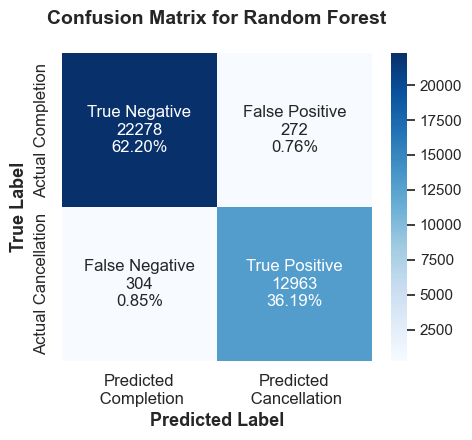

In [142]:
# Create confusion matrix with annotations
# Define confusion matrix groups
group_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']

# Compute values for confusion matrix
selected_model_cm = metrics.confusion_matrix(y_test, y_pred, labels = random_forest_model.classes_)

# Format values for display
group_counts = ['{0:0.0f}'.format(value) for value in selected_model_cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in selected_model_cm.flatten() / np.sum(selected_model_cm)]

# Create labels
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)

# Define labels for x- and y-ticks
ytick_labels = ['Actual Completion', 'Actual Cancellation']
xtick_labels = ['Predicted\n Completion', 'Predicted\n Cancellation']

# Plot heatmap with annotations
plt.figure(figsize = (5, 4))
sns.heatmap(selected_model_cm, annot = labels, fmt = '', cmap = 'Blues', annot_kws = {"size": 12},
            xticklabels = xtick_labels, yticklabels = ytick_labels)

# Set font size for ticks
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

# Set axis labels and title
plt.xlabel('Predicted Label', fontsize = 13, weight = 'bold')
plt.ylabel('True Label', fontsize = 13, weight = 'bold')
plt.title('Confusion Matrix for Random Forest\n', fontsize = 14, weight = 'bold')

plt.show()